# Figure 3

In [ ]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import et_precip_ppe.plot as ppeplot
import et_precip_ppe.load as ppeload
import et_precip_ppe.analyze as ppealyz

numpy     : 1.24.4
matplotlib: 3.8.0
sys       : 3.11.6 | packaged by conda-forge | (main, Oct  3 2023, 10:40:35) [GCC 12.3.0]
xarray    : 2023.10.1



In [2]:
# Get plotting settings
ppeplot.setup_plotting_workspace()

## Load model output

In [3]:
# Get area weights
cesm_weights = xr.open_dataset("/glade/work/bbuchovecky/PPE_analysis/weights/COUP_PPE_weights_atmgrid.nc").rename({"globweights": "globalweights"})
assert cesm_weights.landweights.sum(dim=["lat", "lon"]) == 1

hadcm_weights = xr.open_dataset('/glade/work/bbuchovecky/HadCM3_analysis/weights/HadCM3_weights_v2.nc')
assert hadcm_weights.landweights.sum(dim=["lat", "lon"]) == 1

# Identify variables to load
varlist = ["T_S", "P", "ET", "RH_S", ]

# Load time-mean variables
cesm_ppe, cesm_std = ppeload.get_cesm(varlist, "time_mean")
hadhst_ppe, hadhst_std = ppeload.get_hadcm(varlist, "control", "time_mean")
hada1b_ppe, hada1b_std = ppeload.get_hadcm(varlist, "a1b", "time_mean")
dict_cmip_co2, dict_cmip_pi, dict_cmip_weights = ppeload.get_cmip(varlist, "time_mean")

# Store list of CMIP model names
cmip_models = list(dict_cmip_co2.keys())

# Interpolate CMIP variables to a common grid
dlat = 1.9
dlon = 2.50
new_lat = np.arange(-90, 90+dlat, dlat)
new_lon = np.arange(0, 360, dlon)

cmip_landfrac = dict_cmip_weights['CESM2']['landfrac'].interp(lon=new_lon, lat=new_lat, method='linear')

cmip_co2 = dict()
cmip_pi = dict()

for v in varlist:
    co2_list = []
    pi_list = []

    for m in cmip_models:
        co2_list.append(dict_cmip_co2[m][v].interp(lon=new_lon, lat=new_lat, method='linear'))
        pi_list.append(dict_cmip_pi[m][v].interp(lon=new_lon, lat=new_lat, method='linear'))
    
    cmip_co2[v] = xr.concat(co2_list, dim='model', coords='minimal', compat='override').assign_coords(model=("model", np.arange(7)), model_name=("model", cmip_models))
    cmip_pi[v] = xr.concat(pi_list, dim='model', coords='minimal', compat='override').assign_coords(model=np.arange(7), model_name=("model", cmip_models))

# Compute the delta (perturbed - control)
cesm_delta = dict()
hadhst_delta = dict()
hada1b_delta = dict()
cmip_delta = dict()

for v in varlist:
    cesm_delta[v] = cesm_ppe[v] - cesm_std[v]
    hadhst_delta[v] = hadhst_ppe[v] - hadhst_std[v]
    hada1b_delta[v] = hada1b_ppe[v] - hada1b_std[v]
    cmip_delta[v] = cmip_co2[v] - cmip_pi[v]

    cmip_delta[v] = cmip_delta[v].stack(member=['model', 'experiment'])

# Compute the land and ocean mean
cesm_delta_areamean = dict()
hadhst_delta_areamean = dict()
hada1b_delta_areamean = dict()
cmip_delta_areamean = dict()

for w, weight in zip(["lm", "om"], ["landweights", "oceanweights"]):
    try:
        cesm_delta_areamean[w];
        hadhst_delta_areamean[w];
        hada1b_delta_areamean[w];
        cmip_delta_areamean[w];
    except KeyError:
        cesm_delta_areamean[w] = dict()
        hadhst_delta_areamean[w] = dict()
        hada1b_delta_areamean[w] = dict()
        cmip_delta_areamean[w] = dict()

    assert np.round(cesm_weights[weight].sum(), 3) == 1.
    assert np.round(hadcm_weights[weight].sum(), 3) == 1.

    for v in varlist:
        cesm_delta_areamean[w][v] = cesm_delta[v].weighted(cesm_weights[weight]).mean(dim=["lat", "lon"])
        hadhst_delta_areamean[w][v] = hadhst_delta[v].weighted(hadcm_weights[weight]).mean(dim=["lat", "lon"])
        hada1b_delta_areamean[w][v] = hada1b_delta[v].weighted(hadcm_weights[weight]).mean(dim=["lat", "lon"])

        cmip_list = []
        for m in cmip_models:
            assert np.round(dict_cmip_weights[m][weight].sum(), 3) == 1.
            co2 = dict_cmip_co2[m][v].weighted(dict_cmip_weights[m][weight]).mean(dim=["lat", "lon"])
            pi = dict_cmip_pi[m][v].weighted(dict_cmip_weights[m][weight]).mean(dim=["lat", "lon"])
            cmip_list.append(co2 - pi)
        cmip_delta_areamean[w][v] = xr.concat(cmip_list, dim='model', coords='minimal', compat='override').assign_coords(model=("model", np.arange(7)), model_name=("model", cmip_models)).stack(member=['model', 'experiment'])


# Compute \delta (P-E)
for w in ["lm", "om"]:
    cesm_delta_areamean[w]["PmE"] = cesm_delta_areamean[w]["P"] - cesm_delta_areamean[w]["ET"]
    hadhst_delta_areamean[w]["PmE"] = hadhst_delta_areamean[w]["P"] - hadhst_delta_areamean[w]["ET"]
    hada1b_delta_areamean[w]["PmE"] = hada1b_delta_areamean[w]["P"] - hada1b_delta_areamean[w]["ET"]
    cmip_delta_areamean[w]["PmE"] = cmip_delta_areamean[w]["P"] - cmip_delta_areamean[w]["ET"]

CESM2 time_mean:
  T_S
  P
  ET
  RH_S
HadCM3 control time_mean:
  T_S
  P
  ET
  RH_S
HadCM3 a1b time_mean:
  T_S
  P
  ET
  RH_S
CMIP6 time_mean:
  CESM2 -- T_S, P, ET, RH_S, 
  CanESM5 -- T_S, P, ET, RH_S, 
  GISS-E2-1-G -- T_S, P, ET, RH_S, 
  HadGEM3-GC31-LL -- T_S, P, ET, RH_S, 
  IPSL-CM6A-LR -- T_S, P, ET, RH_S, 
  MIROC6 -- T_S, P, ET, RH_S, 
  MRI-ESM2-0 -- T_S, P, ET, RH_S, 



## Create the figure

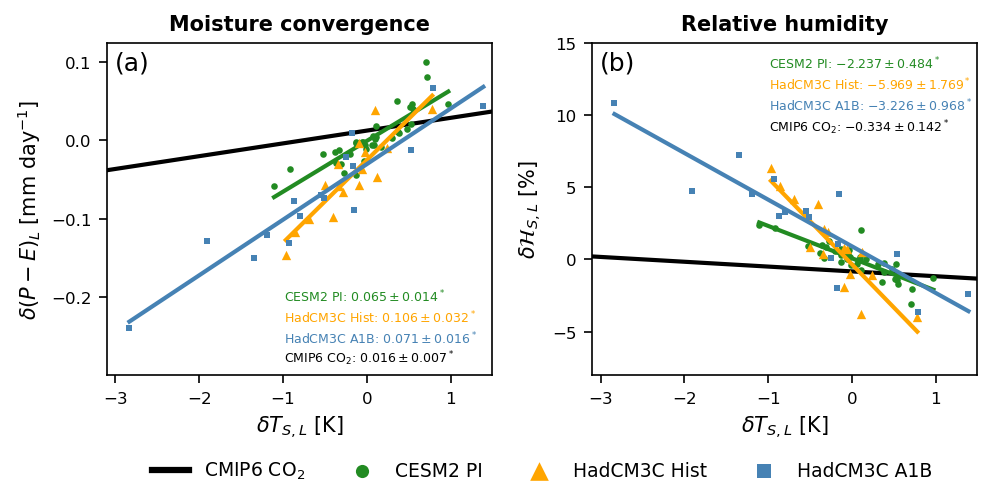

In [ ]:
fig, axs = plt.subplots(
    2, 2, figsize=(6.5, 3.25),
    height_ratios=[1,0.08],
    layout='constrained')
ax = axs.flatten()

## Create separate axis for the legend
gs = ax[2].get_gridspec()
for a in ax[2:4]:
    a.remove()
axleg = fig.add_subplot(gs[2:4])

## Set up axis limits
xa_bnds = [-3.1, 1.5]; ya_bnds = [-0.3, 0.125]
xb_bnds = [-3.1, 1.5]; yb_bnds = [-8,   15]

## Plotting directions
sm = 'lm'
xa = 'T_S'; ya = 'PmE'
xb = 'T_S'; yb = 'RH_S'
these_stats = dict(hadhst=dict(), hada1b=dict(), cesm=dict(), cmip=dict())

for i, (xvar, yvar) in enumerate(zip([xa, xb], [ya, yb])):
    ##
    key = "cmip"
    x = cmip_delta_areamean[sm][xvar]
    
    y = cmip_delta_areamean[sm][yvar]
    these_stats[key][yvar] = ppeplot.plot_scatter_regression(ax[i], x, y, ppealyz.ols_single, key, do_scatter=False, do_print=True)
    
    ##
    key = "cesm"
    x = cesm_delta_areamean[sm][xvar]
    y = cesm_delta_areamean[sm][yvar]
    these_stats[key][yvar] = ppeplot.plot_scatter_regression(ax[i], x, y, ppealyz.ols_single, key, do_print=True)

    ##
    key = "hadhst"
    x = hadhst_delta_areamean[sm][xvar]
    y = hadhst_delta_areamean[sm][yvar]
    these_stats[key][yvar] = ppeplot.plot_scatter_regression(ax[i], x, y, ppealyz.ols_single, key, do_print=True)

    ##
    key = "hada1b"
    x = hada1b_delta_areamean[sm][xvar]
    y = hada1b_delta_areamean[sm][yvar]
    these_stats[key][yvar] = ppeplot.plot_scatter_regression(ax[i], x, y, ppealyz.ols_single, key, do_print=True)

## Set axis limits
ax[0].set_xlim(xa_bnds)
ax[0].set_ylim(ya_bnds)
ax[1].set_xlim(xb_bnds)
ax[1].set_ylim(yb_bnds)

## Set axis tick labels
ax[0].set_yticks([-0.2, -0.1, 0, 0.1])
ax[1].set_yticks([-5, 0, 5, 10, 15])

## Add description of fit statistics to each subplot
def format_label_text(this_stats, key, alpha=0.05):
    ast = ""
    if this_stats["slope_p_value"] < alpha:
        ast = "^*"
    this_label = f"{ppeplot.label_dict[key]}: ${this_stats['slope']: 0.3f} \\pm {this_stats['slope_ci_halfwidth']: 0.3f}{ast}$"
    return this_label

stats_xpos = 0.46
stats_height = 0.25

for j, key in enumerate(["cesm", "hadhst", "hada1b", "cmip"]):
    ax[0].text(
        stats_xpos, 0.025+(3-j)*(stats_height/4),
        format_label_text(these_stats[key]["PmE"], key, alpha=0.05),
        fontsize=6, color=ppeplot.c_dict[key],
        ha='left', va='bottom',
        transform=ax[0].transAxes
    )

    ax[1].text(
        stats_xpos, 0.775+(3-j)*(stats_height/4),
        format_label_text(these_stats[key]["RH_S"], key, alpha=0.05),
        fontsize=6, color=ppeplot.c_dict[key],
        ha='left', va='top',
        transform=ax[1].transAxes
    )

## Set axis labels
ax[0].set_xlabel('$\delta T_{S,L}$ [K]', fontsize=10)
ax[0].set_ylabel('$\delta (P-E)_L$ [mm day$^{-1}$]', fontsize=10)
ax[1].set_xlabel('$\delta T_{S,L}$ [K]', fontsize=10)
ax[1].set_ylabel('$\delta \\mathcal{H}_{S,L}$ [%]', fontsize=10)

## Set title
ax[0].set_title("Moisture convergence", fontweight="bold", fontsize=10)
ax[1].set_title("Relative humidity", fontweight="bold", fontsize=10)

## Create legend
h, l = ax[0].get_legend_handles_labels()
leg = axleg.legend(h, l, ncol=4, fontsize=9, loc='center', markerscale=2)
for line in leg.get_lines():
    line.set_linewidth(3.0)
axleg.axis('off')

## Add subplot numbering
for a, letter in zip(ax[:3], ppeplot.figenum[:3]):
    a.text(
        0.02, 0.975, f'({letter})',
        fontsize=12,
        fontweight='regular',
        ha='left', va='top',
        transform=a.transAxes)

fig.align_ylabels(ax[0])

## Save figure
fig.savefig('fig3.pdf', bbox_inches='tight')